# How do we assess image quality?

**Author Contact:** <br>
Email: 
* [bcchang@utexas.edu](mailto:bcchang@utexas.edu) 
* [jamesmcclure@lbpm-sim.org](mailto:jamesmcclure@lbpm-sim.org)

Two key factors will always be required to generate good simulations
* pore space is connected
* image resolution is sufficient to capture rock microstructure

Morphological analysis provides a quick and easy (cheap!) way to verify that images are worth additional effort

(it is also a great way to initialize oil-water configurations)
______

## 0. Import some packages

In [3]:
# Utility packages
from pathlib import Path
from dpm_tools.io import read_image, Image

# Data processing packages
import pandas as pd
import numpy as np
import skimage
from dpm_tools.metrics import minkowski_functionals

# Image visualization
import matplotlib.pyplot as plt

# Jupyter widgets
from ipywidgets import interact, interactive
import ipywidgets as widgets
from IPython.display import display, clear_output

### 0.1 We will continue evaluating the same bead pack and Mt. Gambier limestone images.

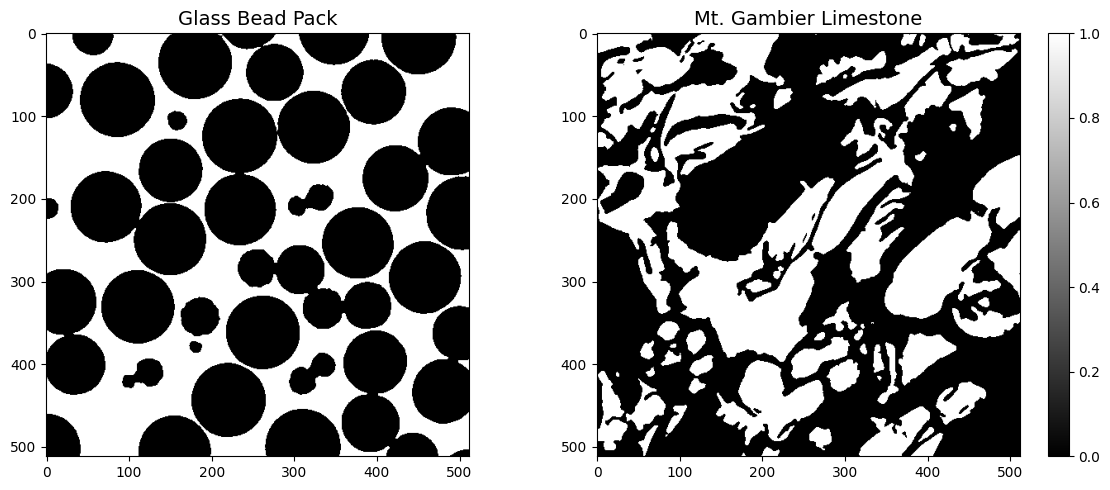

In [5]:
img_list = Path('../data/').glob('*.tif')
beadpack, gambier = [read_image(tif_img) for tif_img in sorted(img_list)]

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = ax.flatten()

im = ax[0].imshow(beadpack[0,:,:], cmap='gray', interpolation=None)
ax[0].set_title('Glass Bead Pack',fontsize=14)

im2 = ax[1].imshow(gambier[0,:,:], cmap='gray', interpolation=None)
ax[1].set_title('Mt. Gambier Limestone',fontsize=14)

plt.colorbar(im2)
plt.tight_layout()
plt.show()

## 1. Running morphological drainage with DPM Tools

The morphological drainage simulation demonstrated here was originally proposed in Hilpert and Miller (2001) [[1]](#1) and was developed for the LBPM software [[2]](#2). The algorithm estimates the multiphase fluid configurations for a given porous medium. Morphological drainage is a useful pre-processing tool for computational SCAL workflows, such as in multiphase lattice Boltzmann simulations.

In this case, we use morphological drainage simulations to assess whether the image resolution is sufficient to capture rock microstructure.

The algorithm operates as follows:
    
1. The Euclidean distance transform is applied to the input binary image. The maximum value of the distance transform is interpreted as the radius for the largest sphere that can be inserted into the pore space.
2. Perform morphological erosion for the pore space with the specified sphere radius.
3. Label the eroded pore space, and leave only the pore space that is still connected with the non-wetting phase.
4. Perform morphological dilation for the labelled pore space with specified radius.
5. Compute the wetting phase saturation of the result of step 4.
6. Decrease the sphere radius. This smaller sphere covers a larger fraction of the pore space (i.e. more non-wetting phase can invade the pore space).
7. Repeat steps 2-5 until a target saturation is achieved. 


Inputs are:
* a digital rock image
* a target wetting phase saturation value (i.e. how much oil to inject using a drainage process)

Outputs are:
* a digital rock image with estimated oil configuration at target wetting phase saturation
* a list of the water saturation `Sw` and radius `r`


This algorithm has been wrapped in a convenient function, ``morph_drain`` in the DPM Tools package.



# Let's look at the beadpack first

This image is fairly homogeneous and well-resolved

We will try to perform morphological drainage using DPM Tools with a target saturation `Sw = 0.30`.

Because this process is written in Python, it may take a few minutes to run. We also provide the results in the ``../data/beadpack_morphdrain.csv`` files.


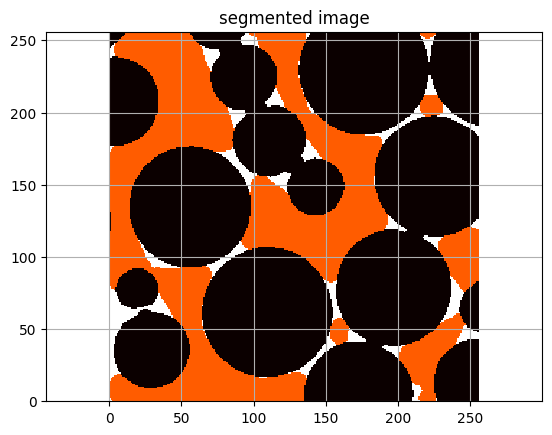

In [3]:
def PlotMorphImage(input_file) :
    ID=tifffile.imread(input_file)
    plt.figure(2)
    plt.title('segmented image')
    plt.pcolormesh(ID[100,:,:],cmap='hot')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    

PlotMorphImage("../data/morphdrain/segmented_bead_pack_256_morphdrain.tif")

# Mercury injection curve

Radius of morphological opening is decreased to decrease the water saturation. 

This provides a fair approximation of oil drainage under water wet conditions 
(may miss irredicuble water saturation)

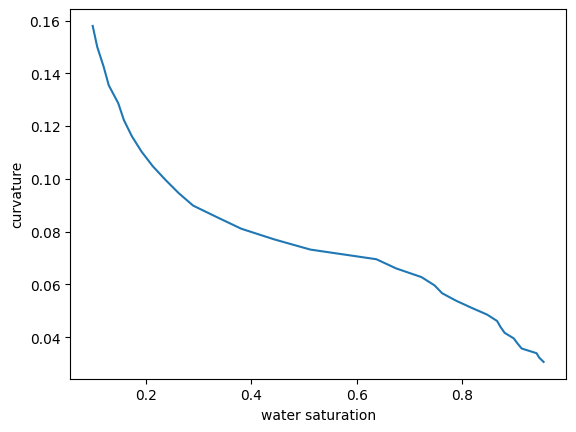

In [4]:
M=pd.read_csv("../data/lbpm/beadpack/morphdrain.csv",sep=" ")

pc=1/M['radius']
plt.figure()
plt.plot(M['sw'],pc)
plt.xlabel('water saturation')
plt.ylabel('curvature')
plt.show()

# Morphological Drainage as Image Quality Control

* The morphological opening tells us how large the flow channels are likely to be
* Under-resolved flow channels will lead to "bad" simulation results
* It will be clear if the porespace is not well-connected
* Rule of thumb: 10 voxels across a pore-throat will ensure scale separation between water films and flow channels

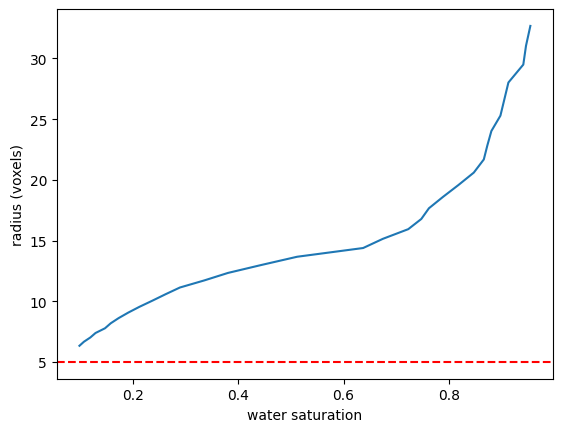

In [5]:
plt.figure()
plt.plot(M['sw'],M['radius'])
plt.axhline(y=5,color='r',linestyle='dashed')
plt.xlabel('water saturation')
plt.ylabel('radius (voxels)')
plt.show()

# Now consider the Castlegate sandstone

Relevant content of `input.db`
```
Domain {
   Filename = "segmented_castle_512.ubc"
   voxel_length = 5.6
   N = 512, 512, 512
   n = 256, 256, 256
   nproc = 1, 1, 1
   ReadType ="8bit"
   // key values set by image labeling 
   ReadValues = 0, 1, 2 
   WriteValues = 1, 0, 2 
   // keys below set by color model
   BC = 0
   InletLayers = 0, 0, 5 
   OutletLayers = 0, 0, 5 
   Sw = 0.05
}
```



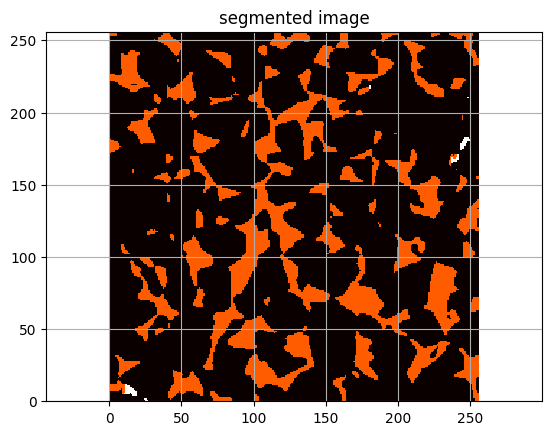

In [6]:
PlotMorphImage("../data/morphdrain/segmented_castle_256_morphdrain5.tif")

## (note how obvious the irreducible water saturation is for this image)

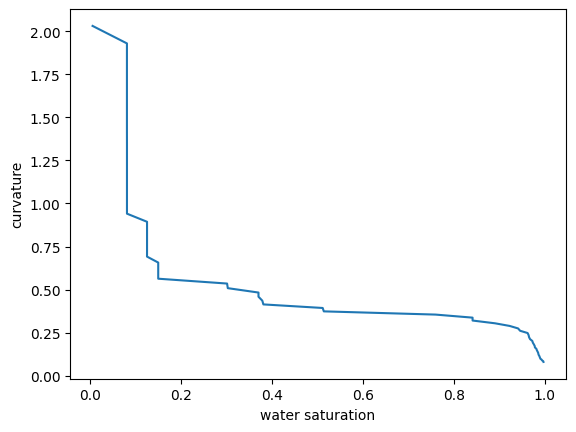

In [8]:
M=pd.read_csv("../data/lbpm/castle/morphdrain.csv",sep=" ")

pc=1/M['radius']
plt.figure()
plt.plot(M['sw'],pc)
plt.xlabel('water saturation')
plt.ylabel('curvature')
plt.show()

# Quality control check

### Morphological radius clearly shows that the flow pathways will break my rule of thumb!

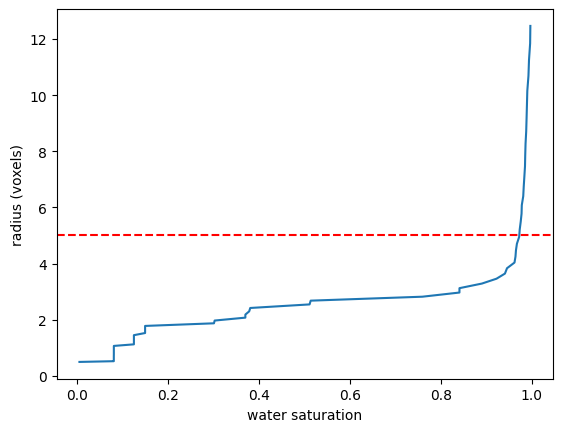

In [9]:
plt.figure()
plt.plot(M['sw'],M['radius'])
plt.axhline(y=5,color='r',linestyle='dashed')
plt.xlabel('water saturation')
plt.ylabel('radius (voxels)')
plt.show()

# Gambier 

```
Domain {
   Filename = "segmented_Gambier_512.ubc"
   voxel_length = 3.0
   N = 512, 512, 512
   n = 256, 256, 256
   nproc = 1, 1, 1
   ReadType ="8bit"
   // key values set by image labeling 
   ReadValues = 0, 1, 2 
   WriteValues = 1, 0, 2 
   // keys below set by color model
   BC = 0
   InletLayers = 0, 0, 5 
   OutletLayers = 0, 0, 5 
   Sw = 0.1
}
```

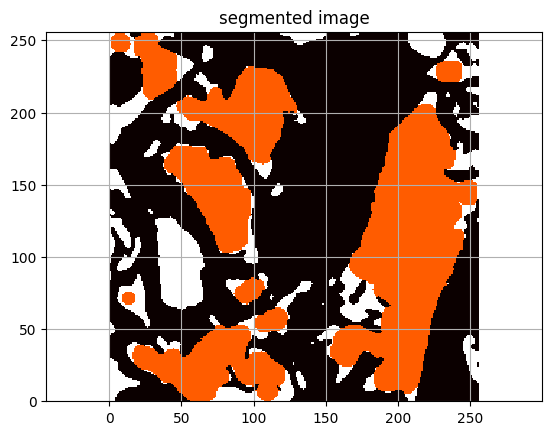

In [10]:
PlotMorphImage("../data/morphdrain/segmented_Gambier_256_morphdrain30.tif")

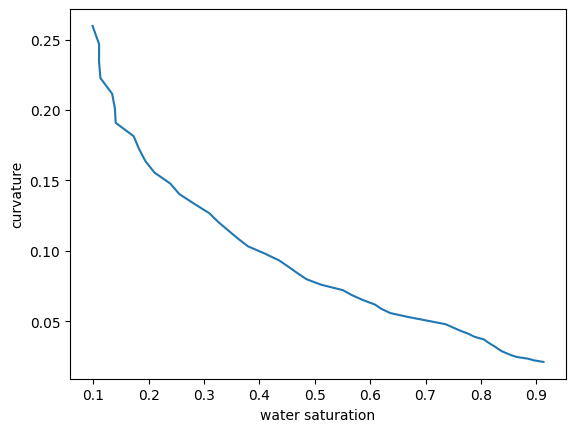

In [11]:
M=pd.read_csv("../data/lbpm/gambier/morphdrain.csv",sep=" ")

pc=1/M['radius']
plt.figure()
plt.plot(M['sw'],pc)
plt.xlabel('water saturation')
plt.ylabel('curvature')
plt.show()

# Quality control check

### Morphological radius clearly shows that the flow pathways will break my rule of thumb!

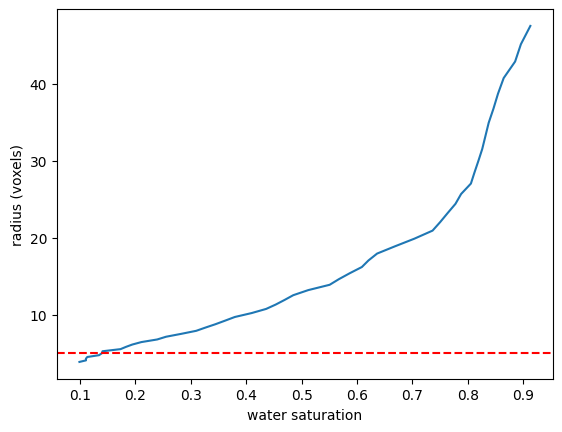

In [12]:
plt.figure()
plt.plot(M['sw'],M['radius'])
plt.axhline(y=5,color='r',linestyle='dashed')
plt.xlabel('water saturation')
plt.ylabel('radius (voxels)')
plt.show()

## References
<a id="1">[1]</a> 
Hilpert, M. and Miller, C. T. (2001). 
Pore-morphology-based simulation of drainage in totally wetting porous media.
Advances in Water Resources, Volume 24, doi: [10.1016/S0309-1708(00)00056-7](https://doi.org/10.1016/S0309-1708(00)00056-7)

<a id="2">[2]</a> 
McClure, J.E., Li, Z., Berrill, M., and Ramstad, T. (2021). The LBPM software package for simulating
multiphase flow on digital images of porous rocks. Computational Geosciences, Volume 25, Pages 871–895, doi: [10.1007/s10596-020-10028-9](https://doi.org/10.1007/s10596-020-10028-9)
